## Masked Face Recognition with Anti-Spoofing

> 遮盖状态下的活体人脸身份识别项目，是结合`**人脸检测*`、`**活体检测**`以及`**遮挡状态下的人脸特征提取**`的多流程的综合项目，具体步骤细分为：视频-抽帧-人脸检测-人脸关键点对齐-活体检测-人脸比对-人脸识别。具体每个子项目的细节可以查看文件夹`face anti spoofing`和`masked face recognition`。

<img src='note/face_recognition.jpg'></img>

In [2]:
# Analysis
import os
import glob
import numpy as np
import pandas as pd

# Plotting
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

# Framework
import torch
import torch.nn as nn
import torch.nn.functional as F

>### Pretrained Model

先更改相对路径：
- `face anti spoofing`文件夹下的face_anti_spoofing
- `masked face recognition`文件夹下的masked_face_recognition以及config

In [1]:
import os
current_dir = os.path.abspath('./') #从上一级路径的总项目调用时
import sys
sys.path.append(current_dir+'/face_anti_spoofing')
sys.path.append(current_dir+'/masked_face_recognition')
from face_anti_spoofing import *
from masked_face_recognition import *

In [3]:
# 调用活体检测模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
anti_spoofing = FaceAntiSpoofing()

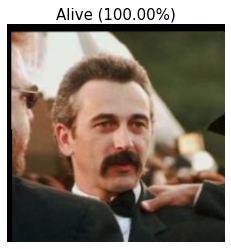

In [5]:
image = cv2.imread('testing/alive.jpg')
label, prob = anti_spoofing.classify(image)
plt.imshow(image[...,::-1])
plt.title(f'Alive ({prob:.2%})' if label else f'Attack ({1-prob:.2%})',fontsize=15)
plt.axis('off');

In [8]:
# 调用人脸识别模型
recognition = MaskedFaceRecognition()
image = cv2.imread('testing/alive.jpg')
emb = recognition.compute_face_descriptor(image)
emb.shape

(128,)

>### Model

部署过程中，遇到的问题：
1. 人脸识别模型的最优dist在1.2左右，怎么对比不同dist下模型的performance呢？是

In [4]:
import dlib
from IPython.display import Video

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import torch
import dlib
import pickle

# 路径
import os
current_dir = os.path.abspath('./') 
import sys
sys.path.append(current_dir+'/face_anti_spoofing')
sys.path.append(current_dir+'/masked_face_recognition')
from face_anti_spoofing import *
from masked_face_recognition import *


# 首先从原图检测人脸，通过关键点对齐提取到水平对齐的脸部截图
class MaskedFaceRecognition_AntiSpoofing():
    def __init__(self):
        super(MaskedFaceRecognition_AntiSpoofing, self).__init__()
        self.img_size = 150 #目的把正脸图resize成正方形，提取人脸特征emb
        
        # 初始化模型
        self.detector = detector #dlib.get_frontal_face_detector() # 人脸检测模型
        self.predictor = predictor #predictodlib.shape_predictor('shape_predictor_68_face_landmarks.dat') #68个关键点检测模型
        self.anti_spoofing = FaceAntiSpoofing() #活体检测模型
        # self.recognizer = recognizer #dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat') #人脸特征提取模型
        self.recognizer = MaskedFaceRecognition() #遮挡状态下的人脸特征提取模型
        self.door_open = False #门禁系统
        self.fake = False #不匹配
        try:
            if self.recognizer.thres is not None: #如果用遮挡模型
                self.thres = self.recognizer.thres #使用最优dist thres
        except:
            self.thres = 0.2 #如果使用dilb，则用0.2
        

    def get_emb(self, image, name=None, similarity=None):
        # 人脸检测，返回bbox坐标
        bboxes = self.detector(image, upsample_num_times=1) #返回bbox坐标[[(x1,y1) (x2,y2)],[...]]
        face_emb = None #初始值
        if len(bboxes) == 1:  #只针对当前主人物进行识别           
            # 对检测到的人脸提取人脸关键点
            landmarks = self.predictor(image, bboxes[0])
            face_align = dlib.get_face_chip(image, face=landmarks, #关键点对齐人脸，旋转恢复水平正面
                                            size=self.img_size) #resize得到放大居中的人脸框截图
            
            # 活体检测
            alive, prob = self.anti_spoofing.classify(face_align) #判断是否为活体(0/1)
            if alive: #如果是活人
                face_emb = self.recognizer.compute_face_descriptor(face_align) #根据水平人脸计算人脸特征emb
                if self.fake: #用了别人的卡刷门禁
                    self.draw_bbox(image, bboxes[0],'red', name, similarity, prob) # 给原图绘制红bbox
                else:
                    self.draw_bbox(image, bboxes[0], 'green', name, similarity, prob) # 给原图绘制绿bbox
            else: #非活体
                self.draw_bbox(image, bboxes[0],'red', name, similarity, prob) # 给原图绘制红bbox
            self.draw_landmarks(image, landmarks) #给原图绘制关键点    
        return face_emb, image     
                
        
    def face_verify(self, face_emb, face_database, target_name=None): 
        name, similarity = None, None #原始值
        if target_name is not None: #比如刷卡等提供身份信息的情况下，直接比对更加迅速
            dist = np.linalg.norm(face_database[target_name] - face_emb) #l2 distance
            if dist < self.thres: 
                name = target_name
                similarity = 1 - dist/np.sqrt(2) #人脸相似度，由于emb是单位向量，距离最大为根号2，所以归一化得到[0,1]
                self.door_open = True
                self.fake = False
            else:
                self.fake = True #不匹配

        else: #否则逐个比对
            self.fake = True #先设为不匹配
            min_thres = self.thres #模型thres为基准
            for target_name, target_emb in face_database.items(): #遍历人脸库
                dist = np.linalg.norm(target_emb - face_emb) #l2 distance
                # print(target_name, dist)
                if dist < min_thres:
                    name = target_name #得到匹配的名字
                    similarity = 1 - dist/np.sqrt(2) 
                    min_thres  = dist
                    self.door_open = True 
                    self.fake = False
        return name, similarity
    
    
    def face_recog(self, video_path=None, face_database=None, target_name=None, save=False):
        # 选择视频流
        if video_path:
            cap = cv2.VideoCapture(video_path) #从视频中读取图像
            save_video = os.path.splitext(video_path)[0]+'_landmark.avi'
            save_image = os.path.splitext(video_path)[0]+'_landmark.jpg'
        else:
            cap = cv2.VideoCapture(0) #调用电脑连接的第0个摄像头(通常为前置）
            save_video = 'webcam_landmark.avi'
            save_image = 'webcam_landmark.jpg'
        
        # 视频属性
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        # avi视频：YUV编码*‘I420’，MPEG-1编码*‘PIMI’，MPEG-4编码*'XVID'
        # flv视频：*‘FLV1’
        fps = cap.get(cv2.CAP_PROP_FPS) 
        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        if save:
            out = cv2.VideoWriter(save_video, fourcc, fps, (w,h)) #一般为(1280,720)
        face_embs = []
        name, similarity = None, None #原始值
        
        # 读取视频流
        while cap.isOpened(): #正常打开
            start=time.time()
            normal, frame = cap.read()
            if not normal: #如果视频播放结束，跳出循环
                break 

            # 人脸检测
            frame = cv2.resize(frame, (w//3, h//3))
            face_emb, frame = self.get_emb(frame, name, similarity)
            if face_emb is not None:
                if len(face_embs)<10: #收集10张视频截图提取到活体的人脸特征
                    face_embs.append(np.array(face_emb)) #把dlib vector转成numpy
                else:
                    face_embs.pop(0) #把最早的emb去掉
                    face_embs.append(np.array(face_emb)) #再增加新截图，维持求最近10张截图的均值
            face_emb = np.mean(face_embs, axis=0) 
            
            # 输出画面
            frame = cv2.resize(frame,(w,h)) # 恢复原图尺寸
            if face_database: #人脸识别状态
                #收集完就进行识别，由于随着视频播放，提取到的face_emb均值会动态变动，比如把口罩摘下带上时，相似度可能会有所改变
                if len(face_embs)==10: 
                    name, similarity = self.face_verify(face_emb, face_database, target_name)
                cv2.imshow('We are recognizing ...', frame)
            else: #视频收集人脸emb状态
                if len(face_embs)<10:
                    condition1='Please hold on for us to recognize your face.'
                    cv2.imshow(condition1, frame)
                else:
                    cv2.destroyWindow(condition1)
                    cv2.imshow('Recognition finished! Please press "q" to quit :)',frame)
            # 保存
            if save:
                out.write(frame) #逐帧保存 
            if cv2.waitKey(1) & 0xff == ord('q'): #维持窗口，实时检测，按q退出
                break
                
        if frame is not None: #如果提前终止播放视频或者是摄像头，就把最后一帧画面输出，若视频播放完毕就没有
            cv2.imwrite(save_image, frame) #保存截图
            # plt.imshow(frame[...,::-1]) #把最后一张图片以RGB显示出来
            # plt.axis('off')
            # plt.show()
        cap.release() #断开视频/摄像头
        if save:
            out.release()
        cv2.destroyAllWindows() #关闭所有窗口
        cv2.waitKey(1) #只用在Jupyter上，防止kernel奔溃
        return face_emb
        
        
    def draw_bbox(self, image, bbox, color='green', name=None, similarity=None, prob=None):
        assert color in ['green','red']
        if color=='green': #活体
            color=(0,255,0)
        elif color=='red': #非活体
            color=(0,0,255)
        cv2.rectangle(image, pt1=(bbox.left(),bbox.top()), #通过bbox.left()得到4个点坐标
                             pt2=(bbox.right(),bbox.bottom()), 
                             color=color, thickness=2) #RGB
       
        if self.fake and name is None:  #无法匹配
            text = 'You are not recognized!!'
            cv2.putText(image, text=text,
                        org=(bbox.left()-5,bbox.top()-6), #框左上角坐标为文字的左下角
                        fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.4, #字体，大小
                        color=(255, 255, 0), thickness=1, lineType=cv2.LINE_AA) #文字颜色，线条粗细
        else:
            text = f'Welcome {name}!!' #匹配

        # 1vsN时，匹配到名字时
        if name and similarity:
            cv2.putText(image, text=text,
                        org=(bbox.left()-5,bbox.top()-20), #框左上角坐标为文字的左下角
                        fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.4, #字体，大小
                        color=(255, 255, 0), thickness=1, lineType=cv2.LINE_AA) #文字颜色，线条粗细
            cv2.putText(image, text=f'(Similarity={similarity:.2%}, Alive={prob:.2f})',
                        org=(bbox.left()-20,bbox.top()-5),
                        fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.3, 
                        color=(255, 255, 0), thickness=1, lineType=cv2.LINE_AA) 


    def draw_landmarks(self, image, landmarks):
        for i in range(68):
            cv2.putText(image, text=str(i), 
                    org=(landmarks.part(i).x, landmarks.part(i).y), #通过landmarks.part(i)得到每个点的坐标
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.3, 
                    color=(0, 255, 255), thickness=1, lineType=cv2.LINE_AA) 
            cv2.circle(image, center=(landmarks.part(i).x, landmarks.part(i).y), 
                   radius=1, color=(0, 0, 255)) #以关键点坐标为圆心画点

> ### Face Database

Get some faces from [person_not_exist](https://thispersondoesnotexist.com) to build up your face library!

In [5]:
import PySimpleGUI as sg
sg.theme("BlueMono")
import pickle

'BlueMono'

In [6]:
# 静态图片批量组建人脸库
FACE_DB_PATH = 'face_database'
glob.glob(FACE_DB_PATH+'/**', recursive=True)

['face_database/',
 'face_database/IT_face_database.pkl',
 'face_database/Madonna',
 'face_database/Madonna/Madonna_0004.jpg',
 'face_database/Madonna/Madonna_0005.jpg',
 'face_database/Madonna/Madonna_0002.jpg',
 'face_database/Madonna/Madonna_0003.jpg',
 'face_database/Madonna/Madonna_0001.jpg',
 'face_database/Mark_Wahlberg',
 'face_database/Mark_Wahlberg/Mark_Wahlberg_0004.jpg',
 'face_database/Mark_Wahlberg/Mark_Wahlberg_0003.jpg',
 'face_database/Mark_Wahlberg/Mark_Wahlberg_0002.jpg',
 'face_database/Mark_Wahlberg/Mark_Wahlberg_0001.jpg']

In [7]:
def photo_emb(name_path):
    image_list = os.listdir(name_path)
    image_list.sort()
    embs = []
    for image in image_list: #每个人的图片路径
        image_path = os.path.join(name_path, image)
        image = cv2.imread(image_path)
        emb, _ = model.get_emb(image)
        embs.append(np.array(emb))
    emb = np.mean(embs, axis=0) #取10张图片预测的emb均值
    return emb


# 多渠道组建人脸库
def create_face_database(model):
    face_database = {}
    finished = False
    print(f'Creating face database ...')        
    while not finished:
        event, values = choose_path()
        if event=='Finish': #完成创建，跳出循环
            break

        filename = f"{values['dep']}_face_database.pkl"
        if values['photo']: 
            if values['image_path']: #单个员工照片
                emb = photo_emb(values['image_path'])
                face_database[values['name']] = emb

            elif values['folder_path']: #批量员工照片
                folder_path  = values['folder_path']
                ppl_list = os.listdir(folder_path) #每个员工提供10张照片
                ppl_list.sort()
                for name in tqdm(ppl_list):
                    name_path = os.path.join(folder_path, name)
                    if os.path.isdir(name_path): #只有在是文件夹的情况下
                        emb = photo_emb(name_path)
                        face_database[name] = emb

        elif values['video']: #视频创建
            emb = model.face_recog(values['video_path']) 
            face_database[values['name']] = emb

        elif values['webcam']: #摄像头
            emb = model.face_recog() 
            face_database[values['name']] = emb
    
    with open(filename, 'wb') as f:
        pickle.dump(face_database, f)
    print(f'Face database for {len(face_database)} staff has been created and saved to {filename}.')
    return face_database

In [8]:
def choose_path(): #GUI可视化窗口，可以根据自定义情况选择员工人脸数据库路径
    window = sg.Window(
        title="创建员工人脸库",
        layout=[
            [sg.Text('部门：'), sg.InputText(key='dep', size=(10,1)),
             sg.Text('姓名：'), sg.InputText(key='name', size=(10,1))],
            [sg.Radio('照片', group_id='R', key='photo', default=True)],
            [sg.Text('单人照片文件夹：'), sg.InputText(key='image_path'), sg.FolderBrowse(initial_folder = os.getcwd())],
            [sg.Text('多人照片文件夹：'), sg.InputText(key='folder_path'), sg.FolderBrowse(initial_folder = os.getcwd())],
            [sg.Radio('视频', group_id='R', key='video')],
            [sg.Text('单人视频文件：'), sg.InputText(key='video_path'), sg.FileBrowse(initial_folder = os.getcwd())],
            [sg.Radio('摄像头', group_id='R', key='webcam')],
            [sg.Button('Start'), sg.Button('Finish')],
        ],
    )
    
    event, values = window.read()
    window.close()
    return event, values

In [82]:
# 初始化模型，在不带口罩的状态下组建人脸库
model = MaskedFaceRecognition_AntiSpoofing()
face_database = create_face_database(model)

Creating face database ...


100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.67s/it]

Face database for 2 staff has been created.


In [9]:
model = MaskedFaceRecognition_AntiSpoofing()

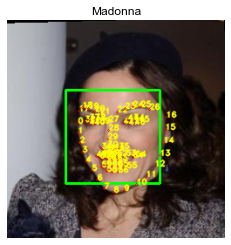

In [18]:
# 可视化以上流程
person_path = os.path.join(FACE_DB_PATH, 'Madonna','Madonna_0005.jpg')
image = cv2.imread(person_path)
emb, image = model.get_emb(image)
plt.imshow(image[...,::-1])
plt.title('Madonna')
plt.axis('off')
plt.show();

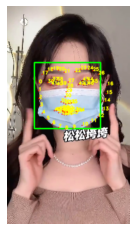

In [27]:
# 动态视频组建人脸库
model = MaskedFaceRecognition_AntiSpoofing()
emb = model.face_recog('testing/masked.mp4')
face_database['Mandy'] = emb

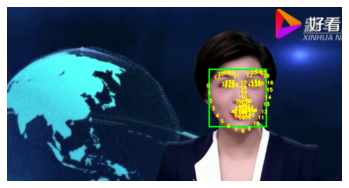

In [21]:
# 动态视频组建人脸库
model = MaskedFaceRecognition_AntiSpoofing()
emb = model.face_recog('testing/news.mov')
face_database['Tina'] = emb

> ### Deployment

In [ ]:
# 实时视频活体人脸识别
emb = model.face_recog('testing/news.mov', face_database=face_database, save=True) #相同人
emb = model.face_recog('testing/news.mov', face_database=face_database, name='Madonna', save=True) #不同人

<img src='note/same.png' width=50%></img>
<img src='note/not_same.png' width=50%></img>